# **Proyecto Final de Curso: Diplomado en Ciencias de Datos - UPTC**
En este es un proyecto de clasificación para ayudar a una compañía financiera a clasificar el puntaje crediticio de sus consumidores en función de la información relacionada con el crédito de los consumidores. La empresa ha estado realizando esta tarea de clasificación manualmente a lo largo de los años y ahora ha decidido construir un sistema inteligente que pueda hacerlo automáticamente utilizando los datos recopilados hasta este momento. La dirección de la empresa le pidió a: *Arvy Nathaniel*, un científico de datos, que ayudara a construir los modelos de clasificación. - Tomado de: *"https://www.kaggle.com/code/arvynathaniel/credit-score-classification-cleaning-ml/notebook"*

Durante este proyecto, harémos uso de las herramientas de análisis exploratorio de datos vistas en clase y desarrollaremos un proyecto de EDA desde cero con base a un dataset de ejemplo en el cuál responderémos diferentes preguntas a cerca de nuestro conjunto de datos con base a las cinco fases básicas del proceso de EDA:

*   Importación de datos y dependencias
*   Detección de valores nulos y duplicados
*   Análisis univariado de variables numéricas
*   Análisis de variables categóricas
*   Análisis bivariado y de correlación
*   Análisis multivariado






# **1.Importación de datos y dependencias**

### 1.1. Dependencias

In [7]:
# Propósito general-- Probamos estas de la clase 3
import warnings
import re
warnings.simplefilter(action='ignore')
# Manejo de datos
import numpy as np
import pandas as pd
from io import StringIO

# Visualización
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# EDA
import missingno
import statsmodels.api as sm
from sklearn.impute import KNNImputer
import scipy.stats as sts
from scipy.stats import ks_2samp
from imblearn.over_sampling import SMOTE
# Pipelines y preprocesamiento
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

### 1.2 Utilidades

**Toolkit de python para transformación de Data**

In [8]:
#--------------------------------------------------------------------------------
#------------------------ Transformador de tipo de datos␣
#------------------------
#--------------------------------------------------------------------------------
def trasnformar_tipo_datos(data, tipos_de_datos):
    df = data.copy()
    for columna, tipo in tipos_de_datos.items():
        df[columna] = df[columna].astype(tipo)
    return df

In [9]:

def convertir_a_entero(columna):
    """
    Convierte una columna de tipo objeto a entero, eliminando los caracteres no numéricos.
    
    Argumentos:
    columna (pandas.Series): Columna de tipo objeto que se desea convertir a entero.
    
    Retorna:
    pandas.Series: Columna convertida a entero.
    """
    
    # Expresión regular para eliminar caracteres no numéricos y guiones negativos
    patron = r'[^0-9-]'
    
    # Eliminar los caracteres no numéricos y guiones negativos
    columna_limpia = columna.apply(lambda x: re.sub(patron, '', str(x)))
    
    # Convertir la columna limpia a entero
    columna_entero = pd.to_numeric(columna_limpia, errors='coerce')
    
    # Reemplazar los valores vacíos por NaN
    columna_entero = columna_entero.fillna(pd.NA)
    
    return columna_entero

In [10]:
#--------------------------------------------------------------------------------
#----------------------- Función para convertir columna a float
#------------------------ Se tiene en cuenta que las columnas contienen caracteres no numéricos, 
#-----------------------  y se usa el punto como separador de lanotación flotante
#--------------------------------------------------------------------------------
# 
def convertir_a_flotante(col):
    try:
        # Intentar convertir directamente a float
        return col.astype(float)
    except ValueError:
        # Remover caracteres no numéricos y convertir a float
        cleaned = col.str.replace('[^0-9.-]', '', regex=True)
        return cleaned.astype(float)


In [11]:
def convertir_a_flotante1(df, column_name):
    """
    Convierte una columna de tipo object a float en un DataFrame de Pandas.
    Si hay valores no numéricos (como "_", " ", "-"), los convierte a NaN.
    
    Parámetros:
    df (pandas.DataFrame): DataFrame que contiene la columna a convertir.
    column_name (str): Nombre de la columna a convertir.
    
    Retorna:
    pandas.Series: La columna convertida a tipo float.
    """
    # Reemplazar los caracteres especiales por NaN
    df[column_name] = df[column_name].replace(['_', ' ', '-'], np.nan, regex=True)
    
    # Convertir la columna a float
    try:
        column_float = df[column_name].astype(float)
    except ValueError:
        # Si hay valores que no se pueden convertir a float, los convierte a NaN
        column_float = pd.to_numeric(df[column_name], errors='coerce')
    
    return column_float

In [44]:
def eliminar_outliers_edad(df):
    """
    Elimina los registros del DataFrame donde la columna 'Age' tiene valores fuera del rango de 1 a 10.
    
    Argumentos:
    df (pandas.DataFrame): DataFrame original.
    
    Retorna:
    pandas.DataFrame: DataFrame sin los registros con valores outliers en la columna 'Age'.
    """
    # Crear una máscara booleana para los valores dentro del rango
    #mask = (df['Age'].apply(float) >= 1) & (df['Age'].apply(float) < 10)
    df['Age'] = df['Age'].apply(float)
    mask = (df['Age'].apply(float) < 18) # Menores de 18 Años y Negativos
    
    # Filtrar el DataFrame utilizando la máscara
    df_filtrado = df[mask]
    
    return df_filtrado

In [13]:
#--------------------------------------------------------------------------------
#--------------------------------- Histogram-Box --------------------------------
#--------------------------------------------------------------------------------

def histogram_box(dataframe, variable):
  df = dataframe
  fig, ax = plt.subplots(1,2,figsize=(14,5))
  # histogram_box plot
  sns.histplot(data=df, x=str(variable), kde=True, ax=ax[0])
  sns.boxplot(data=df, x=str(variable))
  # mean
  mean = df[str(variable)].mean()
  ax[0].axvline(mean, color='red')
  # stats-box
  variance = round(df[str(variable)].var(),2)
  kurtosis = round(df[str(variable)].kurt(),2)
  skewness = round(df[str(variable)].skew(),2)

  textstr = '\n'.join( (r'mean=%.2f' % (mean, ), r'Variance=%.2f' % (variance, ), r'Kurtosis=%.2f' % (kurtosis, ), r'Skewness=%.2f' % (skewness, )) )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
  ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
  ax[0].set_title(f'Histogram of {variable}')
  ax[0].set_xlabel(f'{variable}')
  ax[0].set_ylabel("Frecuency")
  ax[0].grid(True)
  ax[1].set_title(f'Boxplot of {variable}')
  ax[1].set_xlabel(f'{variable}')
  ax[1].set_ylabel("Frecuencias")
  ax[1].grid(True)

  plt.subplots_adjust(hspace=0.5)
  plt.show()

### 1.3 Importación y Descripción General de los datos

El conjunto de Datos objeto de análisis contiene 100.000 Filas (Registros) y 28 Columnas (Variables).
Con este conjunto recopilado de forma manual se pretende ser la base para predecir el puntaje crediticio de cada cliente.
De forma General tenemos:


 El diccionario de los datos es el siguiente:

|Variable|Descripción|Tipología|
|---|---|---|
|ID| Representa un único valor por entrada de registro|Numérica|
|Customer_ID|Ientificación de una (única) persona|Numérica|
|Month|Representa el mes del Año|Categórica|
|Name|Nombre de la persona|Categórica|
|Age|La edad de la persona|numérico|
|SSN|Número de Identificación de Seguridad|Numérica|
|Occupation|Representa la ocupación de la persona|Categórica|
|Annual_Income|Ingreso Anual de la persona|Numérica|
|Monthly_Inhand_Salary|Salario base mensual de la persona|Numérica|
|Num_Bank_Accounts|Representa el Número de Cuentas bancarias de la persona|Numérica|
|Num_Credit_Card|Representa la cantidad de otras tarjetas de crédito que tiene la persona|Numérica|
|Interest_Rate|Representa la tasa de interés de la tarjeta de crédito|Numérica|
|Num_of_Loan|Representa el número de préstamos tomados del banco por la persona|Numérica|
|Type_of_Loan|Representa el tipo de crédito que tiene la persona|Categórica|
|Delay_from_due_date|Representa el promedio numérico de dias de atraso desde la fecha de pago|Numérica|
|Num_of_Delayed_Payment|Reprenta el promedio numérico de pagos atrasados de la persona|Numérica|
|Changed_Credit_Limit|Representa el porcentaje de cambio en el límite de la tarjeta de crédito|Numérica|
|Num_Credit_Inquiries|Reprenta el número de consultas de tarjetas de crédito|Numérica|
|Credit_Mix|Reprenta la clasificación de la mezcla de créditos|Categórica|
|Outstanding_Debt|Representa el faltante de la deuda por pagar (saldo en USD)|Numérica|
|Credit_Utilization_Ratio|Reprenta el radio de utilización del creédito|Numérica|
|Credit_History_Age|Reprenta la edad de la vida crediticia de la persona|Numérica|
|Payment_of_Min_Amount|Reprenta si la persona sólo pago la cantidad mínima|Categórica|
|Total_EMI_per_month|Reprenta el total de pagos EMI (cuotas mensuales equivalentes)|Numérica|
|Amount_invested_monthly|Reprenta las inversiones mensuales de las personas (Seguros, ahorro, etc.)|Numérica|
|Payment_Behaviour|Reprenta el comportamiento de pago del cliente|Categórica|
|Monthly_Balance|Reprenta el balance mensual del cliente (En USD)|Numérica|


In [14]:
# Importación de datos
path = './train.csv'
raw_df = pd.read_csv(path,low_memory=False)

## 1.3.1 Información General del DataSet

Descripción General de los tipos de variables usados en el Conjunto de Datos, obtenemos información adicional de los valores encontrads por cada variable.

In [15]:
#información del Dataset
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

El dataset tiene varias inconsistencias que señalizarán más adelante, se corregirán las nesarias, ya que en esencia es lo que corresponde a la Etapa EDA (Análisi Exploratorio de Datos), por ejemplo: El tipo de dato para ID, debe ser Entero, no un Object.

In [16]:
#los primeros 5 datos
raw_df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## 1.4 Descripción de Algunas Variables del Modelo

De forma General y con el ánimo de entender mejor el Conjunto de datos, vamos a describir algunas de sus variables.


### 1.4.1 Changed_Credit_Limit

In [17]:
#Variable a revisar: "Changed_Credit_Limit"
descripcion_variable = 'Changed_Credit_Limit: es una variable que rastrea los cambios en los límites de crédito de un prestatario\n' + \
                       'proporcionando información valiosa sobre cómo los acreedores perciben el riesgo del prestatario y su capacidad\n' + \
                       'para manejar el crédito a lo largo del tiempo.\n'+\
                       'Esta variable puede tomar diferentes formas dependiendo del contexto, pero generalmente se expresa \n' + \
                       'como un valor numérico que representa el aumento o disminución en el límite de crédito. Por ejemplo:\n\n' + \
'*   Un valor positivo (ej. 1000) indicaría que el límite de crédito se incrementó en esa cantidad (ej. de $5,000 a $6,000). \n' + \
'**  Un valor negativo (ej. -500) indicaría que el límite de crédito se redujo en esa cantidad (ej. de $10,000 a $9,500). \n' + \
'*** Un valor de cero (0) indicaría que no hubo cambios en el límite de crédito durante ese período. \n' 

print(descripcion_variable)
raw_df["Changed_Credit_Limit"].describe()

Changed_Credit_Limit: es una variable que rastrea los cambios en los límites de crédito de un prestatario
proporcionando información valiosa sobre cómo los acreedores perciben el riesgo del prestatario y su capacidad
para manejar el crédito a lo largo del tiempo.
Esta variable puede tomar diferentes formas dependiendo del contexto, pero generalmente se expresa 
como un valor numérico que representa el aumento o disminución en el límite de crédito. Por ejemplo:

*   Un valor positivo (ej. 1000) indicaría que el límite de crédito se incrementó en esa cantidad (ej. de $5,000 a $6,000). 
**  Un valor negativo (ej. -500) indicaría que el límite de crédito se redujo en esa cantidad (ej. de $10,000 a $9,500). 
*** Un valor de cero (0) indicaría que no hubo cambios en el límite de crédito durante ese período. 



count     100000
unique      4384
top            _
freq        2091
Name: Changed_Credit_Limit, dtype: object

In [18]:
#Variable a revisar: "Changed_Credit_Limit"
descripcion_variable = 'Para nuestro caso de estudio está dado como un Porcentaje de Incremento o Decremento del Valor Inicial Pactado/ Ofrecido.\n'
print(descripcion_variable)
raw_df["Changed_Credit_Limit"]
print(raw_df["Amount_invested_monthly"])
print('\n Veamos el describe(): \n\n', raw_df["Amount_invested_monthly"].describe())

Para nuestro caso de estudio está dado como un Porcentaje de Incremento o Decremento del Valor Inicial Pactado/ Ofrecido.

0         80.41529543900253
1        118.28022162236736
2           81.699521264648
3         199.4580743910713
4        41.420153086217326
                ...        
99995     60.97133255718485
99996     54.18595028760385
99997     24.02847744864441
99998    251.67258219721603
99999     167.1638651610451
Name: Amount_invested_monthly, Length: 100000, dtype: object

 Veamos el describe(): 

 count         95521
unique        91049
top       __10000__
freq           4305
Name: Amount_invested_monthly, dtype: object


### 1.4.2 Num_of_Delayed_Payment

In [19]:
#Variable a revisar: "Num_of_Delayed_Payment"
descripcion_variable = 'Num_of_Delayed_Payment:  es una variable que indica los dias de retraso que tiene un acreedor.\n'

print(descripcion_variable)
#raw_df["Num_of_Delayed_Payment"]
print(raw_df["Num_of_Delayed_Payment"])
print('\n Veamos el describe(): \n\n', raw_df["Num_of_Delayed_Payment"].describe())

Num_of_Delayed_Payment:  es una variable que indica los dias de retraso que tiene un acreedor.

0          7
1        NaN
2          7
3          4
4        NaN
        ... 
99995      7
99996      7
99997      6
99998    NaN
99999      6
Name: Num_of_Delayed_Payment, Length: 100000, dtype: object

 Veamos el describe(): 

 count     92998
unique      749
top          19
freq       5327
Name: Num_of_Delayed_Payment, dtype: object


### 1.4.3 Credit_Score

In [20]:
#Variable a revisar: "Credit_Score"
descripcion_variable = 'Credit_Score:  Es la variable Objetivo, Inicialmente Categórica, Se podrá Transformar\n'+\
                       ' en un Valor de Probabilidad, para indicar si a un Cliente puede asignar una Tarjeta de Crédito\n'

print(descripcion_variable)
#raw_df["Credit_Score"]
print(raw_df["Credit_Score"])
print('\n Veamos el describe(): \n\n', raw_df["Credit_Score"].describe())

Credit_Score:  Es la variable Objetivo, Inicialmente Categórica, Se podrá Transformar
 en un Valor de Probabilidad, para indicar si a un Cliente puede asignar una Tarjeta de Crédito

0            Good
1            Good
2            Good
3            Good
4            Good
           ...   
99995        Poor
99996        Poor
99997        Poor
99998    Standard
99999        Poor
Name: Credit_Score, Length: 100000, dtype: object

 Veamos el describe(): 

 count       100000
unique           3
top       Standard
freq         53174
Name: Credit_Score, dtype: object


### 1.4.4 Monthly_Balance

In [21]:
#Variable a revisar: "Monthly_Balance"
descripcion_variable = 'Monthly_Balance (Saldo mensual) es una variable comúnmente utilizada en el análisis de crédito y riesgo crediticio\n'+\
'que representa el saldo adeudado por un prestatario al final de cada mes en una cuenta de crédito específica, como una tarjeta de crédito\n'+\
'o línea de crédito.\n\n'+\
'****Algunas características clave de la variable Monthly_Balance:****\n'+\
'--------------------------------------------------------------------\n'+\
'1-Refleja el monto que el prestatario debe después de que se hayan aplicado los pagos, cargos, intereses y cualquier otra transacción \n'+\
'ocurrida durante ese mes.\n'+\
'2-Generalmente se presenta como un valor numérico que puede ser positivo (si hay un saldo pendiente) o cero (si no hay saldo pendiente).\n'+\
'3-Es una variable dinámica que puede cambiar mes a mes dependiendo del comportamiento de pago y uso del crédito del prestatario.\n'+\
'4-Los acreedores analizan los patrones de saldos mensuales para evaluar la capacidad del prestatario para administrar su deuda y realizar pagos oportunos.\n'+\
'5-Un saldo mensual alto y persistente puede ser una señal de que el prestatario está teniendo dificultades para pagar o está utilizando demasiado crédito.\n'+\
'6-Un saldo mensual bajo o cero puede indicar que el prestatario está manejando su deuda de manera efectiva y realizando pagos adecuados.\n'+\
'--------------------------------------------------------------------\n'
print(descripcion_variable)
print(raw_df["Monthly_Balance"]+'\n')
print('\n Imprimiendo el describe(): \n', raw_df["Monthly_Balance"].describe())

Monthly_Balance (Saldo mensual) es una variable comúnmente utilizada en el análisis de crédito y riesgo crediticio
que representa el saldo adeudado por un prestatario al final de cada mes en una cuenta de crédito específica, como una tarjeta de crédito
o línea de crédito.

****Algunas características clave de la variable Monthly_Balance:****
--------------------------------------------------------------------
1-Refleja el monto que el prestatario debe después de que se hayan aplicado los pagos, cargos, intereses y cualquier otra transacción 
ocurrida durante ese mes.
2-Generalmente se presenta como un valor numérico que puede ser positivo (si hay un saldo pendiente) o cero (si no hay saldo pendiente).
3-Es una variable dinámica que puede cambiar mes a mes dependiendo del comportamiento de pago y uso del crédito del prestatario.
4-Los acreedores analizan los patrones de saldos mensuales para evaluar la capacidad del prestatario para administrar su deuda y realizar pagos oportunos.
5-Un 

### 1.4.5 Payment_Behaviour

In [22]:
#Variable a revisar: "Payment_Behaviour"
descripcion_variable = 'Payment_Behaviour:  El Payment_Behaviour es una variable crítica para evaluar el riesgo de crédito de un prestatario,\n'+\
                       'ya que proporciona información sobre su historial de cumplimiento de pagos y su capacidad para gestionar \n'+\
                       'sus obligaciones financieras.\n\n'

print(descripcion_variable)
raw_df["Payment_Behaviour"]
print(raw_df["Amount_invested_monthly"])
print('\n Veamos el describe(): \n\n', raw_df["Amount_invested_monthly"].describe())

Payment_Behaviour:  El Payment_Behaviour es una variable crítica para evaluar el riesgo de crédito de un prestatario,
ya que proporciona información sobre su historial de cumplimiento de pagos y su capacidad para gestionar 
sus obligaciones financieras.


0         80.41529543900253
1        118.28022162236736
2           81.699521264648
3         199.4580743910713
4        41.420153086217326
                ...        
99995     60.97133255718485
99996     54.18595028760385
99997     24.02847744864441
99998    251.67258219721603
99999     167.1638651610451
Name: Amount_invested_monthly, Length: 100000, dtype: object

 Veamos el describe(): 

 count         95521
unique        91049
top       __10000__
freq           4305
Name: Amount_invested_monthly, dtype: object


### 1.4.6 Amount_invested_monthly

In [23]:
#Variable a revisar: "Amount_invested_monthly"
descripcion_variable = 'Amount_invested_monthly (Monto Invertido Mensualmente): es una variable que se podría encontrar en un conjunto de datos\n'+\
                       'relacionado con finanzas personales, inversiones o patrones de ahorro.\n'+\
                       'Esta variable representa la cantidad de dinero que un individuo o familia invierte de forma regular, generalmente en un período mensual.\n'

print(descripcion_variable)
print(raw_df["Amount_invested_monthly"])
print('\n Veamos el describe(): \n\n', raw_df["Amount_invested_monthly"].describe())

Amount_invested_monthly (Monto Invertido Mensualmente): es una variable que se podría encontrar en un conjunto de datos
relacionado con finanzas personales, inversiones o patrones de ahorro.
Esta variable representa la cantidad de dinero que un individuo o familia invierte de forma regular, generalmente en un período mensual.

0         80.41529543900253
1        118.28022162236736
2           81.699521264648
3         199.4580743910713
4        41.420153086217326
                ...        
99995     60.97133255718485
99996     54.18595028760385
99997     24.02847744864441
99998    251.67258219721603
99999     167.1638651610451
Name: Amount_invested_monthly, Length: 100000, dtype: object

 Veamos el describe(): 

 count         95521
unique        91049
top       __10000__
freq           4305
Name: Amount_invested_monthly, dtype: object


### 1.4.7 Credit_History_Age

In [24]:
#Variable a revisar: "Credit_History_Age"
descripcion_variable = 'Credit_History_Age Esta variable se mide generalmente en años o meses y refleja\n'+\
                       'el período de tiempo transcurrido desde que el prestatario obtuvo su primera línea de crédito o préstamo. .\n'

print(descripcion_variable)
print(raw_df["Credit_History_Age"])
print('\n Veamos el describe(): \n\n', raw_df["Credit_History_Age"].describe())
raw_df["Credit_History_Age"]

Credit_History_Age Esta variable se mide generalmente en años o meses y refleja
el período de tiempo transcurrido desde que el prestatario obtuvo su primera línea de crédito o préstamo. .

0         22 Years and 1 Months
1                           NaN
2         22 Years and 3 Months
3         22 Years and 4 Months
4         22 Years and 5 Months
                  ...          
99995     31 Years and 6 Months
99996     31 Years and 7 Months
99997     31 Years and 8 Months
99998     31 Years and 9 Months
99999    31 Years and 10 Months
Name: Credit_History_Age, Length: 100000, dtype: object

 Veamos el describe(): 

 count                      90970
unique                       404
top       15 Years and 11 Months
freq                         446
Name: Credit_History_Age, dtype: object


0         22 Years and 1 Months
1                           NaN
2         22 Years and 3 Months
3         22 Years and 4 Months
4         22 Years and 5 Months
                  ...          
99995     31 Years and 6 Months
99996     31 Years and 7 Months
99997     31 Years and 8 Months
99998     31 Years and 9 Months
99999    31 Years and 10 Months
Name: Credit_History_Age, Length: 100000, dtype: object

### 1.4.8 Credit_Utilization_Ratio

In [25]:
#Variable a revisar: "Credit_Utilization_Ratio"
descripcion_variable = 'Credit_Utilization_Ratio  Credit Utilization Ratio se refiere a la proporción del crédito total disponible\n'+\
                        'que un prestatario está utilizando actualmente. Se calcula de la siguiente manera:\n\n'+\
                        '***Credit Utilization Ratio = Deuda Pendiente Total / Límite Total de Crédito Disponible\n'+\
                        '\n\nDonde:\n'+\
                        '*Deuda Pendiente Total: es la suma de todos los saldos pendientes en préstamos, \n'+\
                        'tarjetas de crédito y otras líneas de crédito del prestatario.\n'+\
                        '*Límite Total de Crédito Disponible: es la suma de todos los límites de crédito otorgados al prestatario. .\n'

print(descripcion_variable)
print(raw_df["Credit_Utilization_Ratio"])
print('\n Veamos el describe(): \n\n', raw_df["Credit_Utilization_Ratio"].describe())

Credit_Utilization_Ratio  Credit Utilization Ratio se refiere a la proporción del crédito total disponible
que un prestatario está utilizando actualmente. Se calcula de la siguiente manera:

***Credit Utilization Ratio = Deuda Pendiente Total / Límite Total de Crédito Disponible


Donde:
*Deuda Pendiente Total: es la suma de todos los saldos pendientes en préstamos, 
tarjetas de crédito y otras líneas de crédito del prestatario.
*Límite Total de Crédito Disponible: es la suma de todos los límites de crédito otorgados al prestatario. .

0        26.822620
1        31.944960
2        28.609352
3        31.377862
4        24.797347
           ...    
99995    34.663572
99996    40.565631
99997    41.255522
99998    33.638208
99999    34.192463
Name: Credit_Utilization_Ratio, Length: 100000, dtype: float64

 Veamos el describe(): 

 count    100000.000000
mean         32.285173
std           5.116875
min          20.000000
25%          28.052567
50%          32.305784
75%          36.49666

### 1.4.9 Num_Credit_Inquiries

In [26]:
#Variable a revisar: "Num_Credit_Inquiries"
descripcion_variable = 'Num_Credit_Inquiries: Indica las veces que le hacen consultas por Identificación a un usuario en las centrales de Riesgo (Colombia), \n' + \
                       'representa la cantidad de veces que un prestatario ha solicitado crédito o ha sido objeto de una revisión de su historial crediticio por parte de acreedores potenciales.\n'
print(descripcion_variable)
print(raw_df["Num_Credit_Inquiries"])
print('\n Veamos el describe(): \n\n', raw_df["Num_Credit_Inquiries"].describe())
raw_df["Num_Credit_Inquiries"]

Num_Credit_Inquiries: Indica las veces que le hacen consultas por Identificación a un usuario en las centrales de Riesgo (Colombia), 
representa la cantidad de veces que un prestatario ha solicitado crédito o ha sido objeto de una revisión de su historial crediticio por parte de acreedores potenciales.

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
99995    3.0
99996    3.0
99997    3.0
99998    3.0
99999    3.0
Name: Num_Credit_Inquiries, Length: 100000, dtype: float64

 Veamos el describe(): 

 count    98035.000000
mean        27.754251
std        193.177339
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2597.000000
Name: Num_Credit_Inquiries, dtype: float64


0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
99995    3.0
99996    3.0
99997    3.0
99998    3.0
99999    3.0
Name: Num_Credit_Inquiries, Length: 100000, dtype: float64

# **2. Análisis Exploratorio de Datos  (EDA)**

### 2.1 Selección de las Variables más relevantes (Primera Parte)
De las 28 Variables, en consenso el equipo determina (inicialmente) 18 Variables que se tendrían incidencia en el Score para poder adquirir una tarjeta de crédito.

In [27]:
# primero hacemos una copia del Conjunto raw
# Descripción estadística inicial de los datos numéricos
# Vamos a seleccionar sólo las columnas que requerimos para hacer el análisis
# Copy the dataset
data_credit = raw_df.copy()
relevant_columns = ["ID","Age", "Occupation","Annual_Income","Num_Bank_Accounts","Num_of_Loan", "Delay_from_due_date","Num_of_Delayed_Payment",                    
                    "Changed_Credit_Limit", "Num_Credit_Inquiries", "Credit_Mix","Outstanding_Debt","Credit_Utilization_Ratio","Payment_of_Min_Amount",
                    "Total_EMI_per_month","Amount_invested_monthly","Payment_Behaviour","Monthly_Balance","Credit_Score"]
data_credit = data_credit[relevant_columns]
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_of_Loan               100000 non-null  object 
 6   Delay_from_due_date       100000 non-null  int64  
 7   Num_of_Delayed_Payment    92998 non-null   object 
 8   Changed_Credit_Limit      100000 non-null  object 
 9   Num_Credit_Inquiries      98035 non-null   float64
 10  Credit_Mix                100000 non-null  object 
 11  Outstanding_Debt          100000 non-null  object 
 12  Credit_Utilization_Ratio  100000 non-null  float64
 13  Payment_of_Min_Amount     100000 non-null  ob

### 2.2 Descipción Inicial de los datos numéricos
Inicialmente vamos a explorar los datos mediante visualizaciones y estadísticos principales. Para empezar, observemos la estadística descriptiva básica de nuestros datos numéricos y categóricos.

In [28]:
# Descripción estadística inicial de los datos numéricos
data_credit.describe()

,Num_Bank_Accounts,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,17.091280,21.068780,27.754251,32.285173,1403.118217
std,117.404834,14.860104,193.177339,5.116875,8306.041270
min,-1.000000,-5.000000,0.000000,20.000000,0.000000
25%,3.000000,10.000000,3.000000,28.052567,30.306660
50%,6.000000,18.000000,6.000000,32.305784,69.249473
75%,7.000000,28.000000,9.000000,36.496663,161.224249
max,1798.000000,67.000000,2597.000000,50.000000,82331.000000


In [29]:
# Descripción estadística inicial de datos categóricos
data_credit.describe(include='object')

,ID,Age,Occupation,Annual_Income,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Credit_Mix,Outstanding_Debt,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
count,100000,100000,100000,100000,100000,92998,100000,100000,100000,100000,95521,100000,98800,100000
unique,100000,1788,16,18940,434,749,4384,4,13178,3,91049,7,98792,3
top,0x1602,38,_______,36585.12,3,19,_,Standard,1360.45,Yes,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__,Standard
freq,1,2833,7062,16,14386,5327,2091,36479,24,52326,4305,25513,9,53174


### 2.3 Visualización de Valores Nulos

In [30]:
# Otra forma de hacerlo es:
# Podemos examinar tanto valores null(nulos), como valores nan (not a numeric)
tot = len(data_credit)
nulos = (data_credit.isnull().sum())
nan = (data_credit.isna().sum())
nulidad_null = pd.DataFrame( {'Variable':nulos.index, 'Cantidad Valores Nulo': nulos.values, 'Porcentaje de Nulidad (%) ' :np.round( ((nulos.values/tot)*100),2) } )
#nulidad_nan  = pd.DataFrame( {'Variable':nan.index, 'Cantidad Valores Nan': nan.values, 'Porcentaje de Nan (%) ' :np.round( ((nan.values/tot)*100),2) } )
nulidad_null
#print(nulidad_nan)
#print(tot)


,Variable,Cantidad Valores Nulo,Porcentaje de Nulidad (%)
0,ID,0,0.00
1,Age,0,0.00
2,Occupation,0,0.00
3,Annual_Income,0,0.00
4,Num_Bank_Accounts,0,0.00
5,Num_of_Loan,0,0.00
6,Delay_from_due_date,0,0.00
7,Num_of_Delayed_Payment,7002,7.00
8,Changed_Credit_Limit,0,0.00
9,Num_Credit_Inquiries,1965,1.96




### 2.4 Mapa de Calor de valores Null
Creamos un Mapa de Calor para saber la distribución de los valores faltantes de forma gráfica.

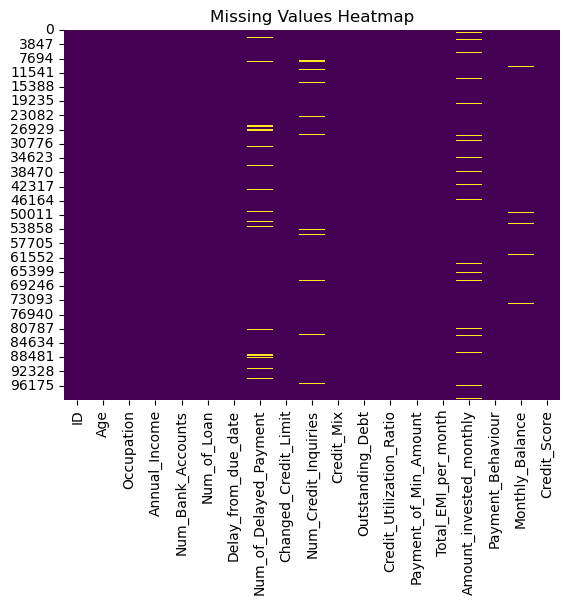

In [31]:
#import seaborn as sns
sns.heatmap(data_credit.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()# Mapa de calor para revisar valores faltantes

El mapa de calor nos indica por ejemplo: que los Valores faltantes de la Variable 'Num_of_DelayedPayment' se encuentran en los rangos de Registros 0-3847, .. 23082-26929,... etc.

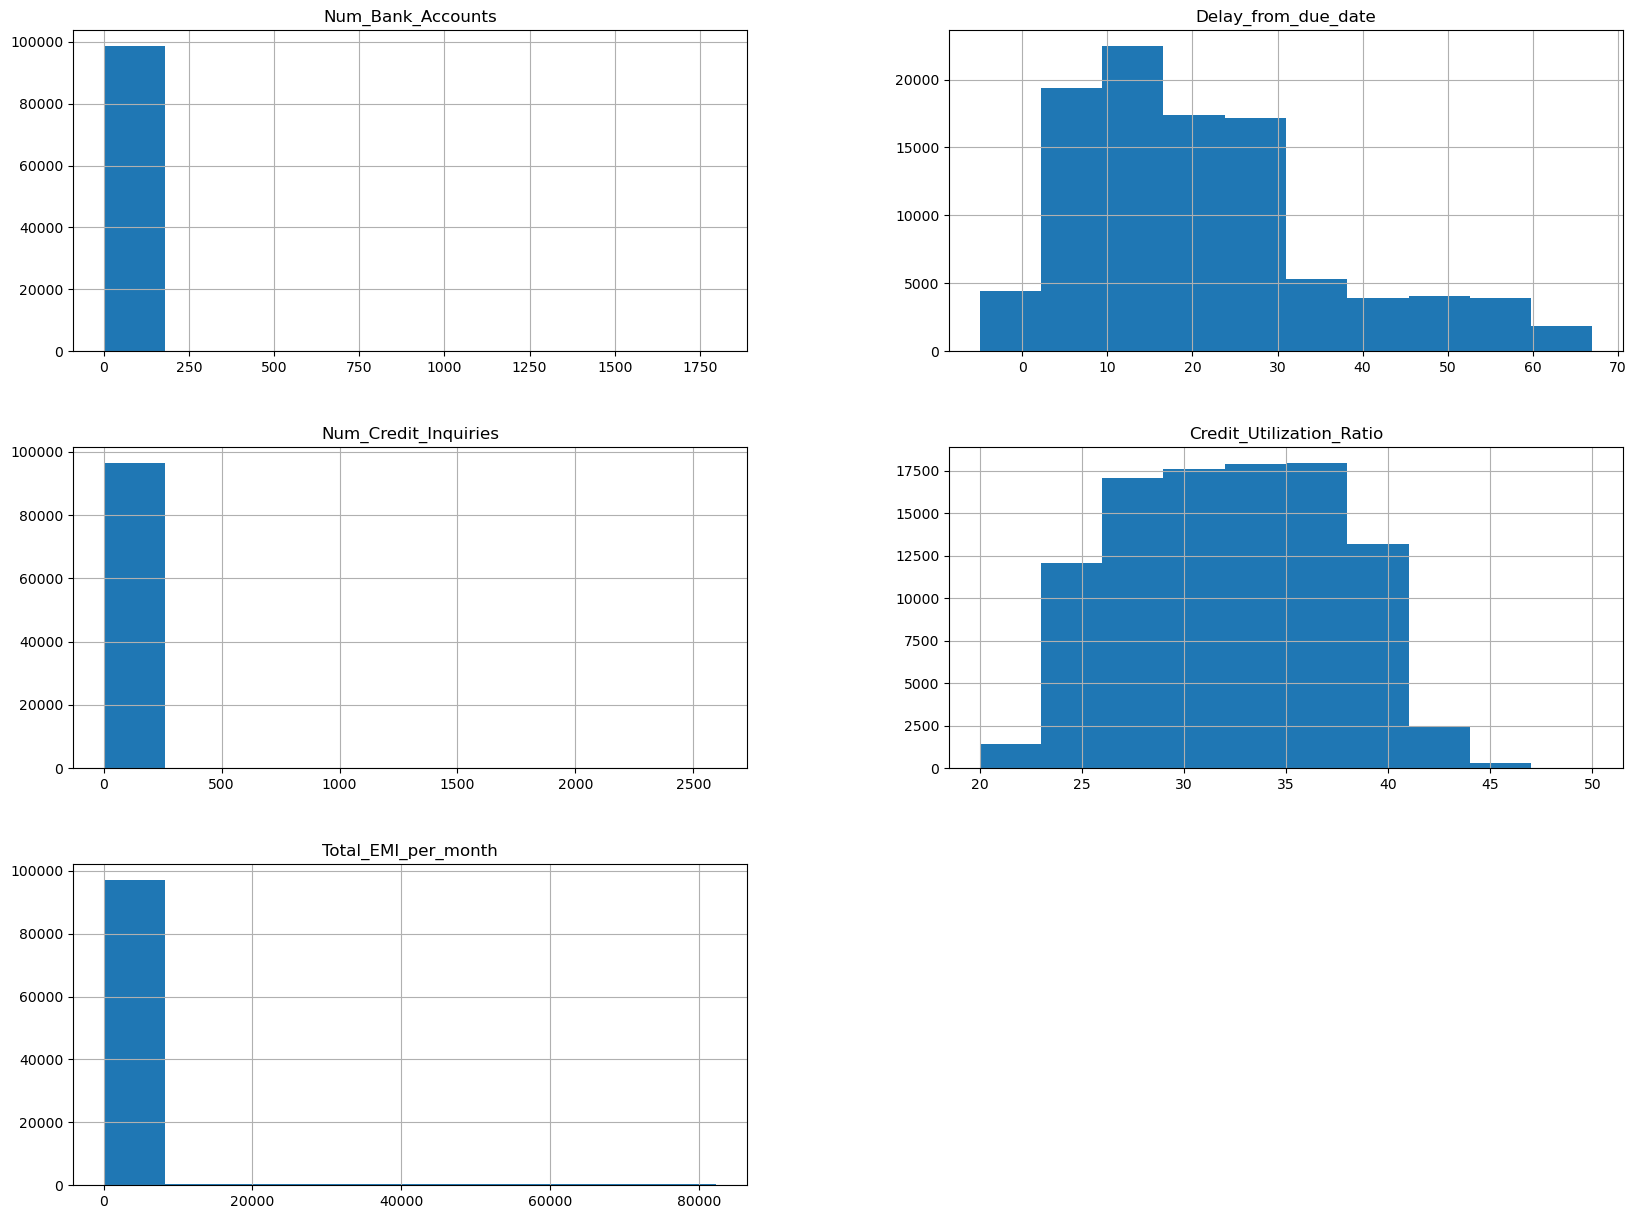

In [83]:
#Visualización de las variables numéricas con histogramas para determinar la distribución de los datos.
data_credit.hist(figsize=(20, 15))
plt.show()

### 2.5 Primera Imputación de los Valores Null (Valor promedio - mean)
Hacemos una primera Imputación para los valores null, con el cálculo de la media

In [32]:
numeric_cols = data_credit.select_dtypes(include='number').columns
data_credit[numeric_cols] = data_credit[numeric_cols].apply(lambda col: col.fillna(col.mean()), axis=0)
print(data_credit)

            ID   Age Occupation Annual_Income  Num_Bank_Accounts Num_of_Loan  \
0       0x1602    23  Scientist      19114.12                  3           4   
1       0x1603    23  Scientist      19114.12                  3           4   
2       0x1604  -500  Scientist      19114.12                  3           4   
3       0x1605    23  Scientist      19114.12                  3           4   
4       0x1606    23  Scientist      19114.12                  3           4   
...        ...   ...        ...           ...                ...         ...   
99995  0x25fe9    25   Mechanic      39628.99                  4           2   
99996  0x25fea    25   Mechanic      39628.99                  4           2   
99997  0x25feb    25   Mechanic      39628.99                  4           2   
99998  0x25fec    25   Mechanic      39628.99                  4           2   
99999  0x25fed    25   Mechanic     39628.99_                  4           2   

       Delay_from_due_date Num_of_Delay

### 2.6 Revisamos que haya quedado bien la Imputación por la media.
Corroborar que los tipos de datos quedaron bien imputados, revisamos nuevamente Valores Null

In [33]:
# Para Corroborar que los tipos de datos quedaron bien imputados, revisamos nuevamente Valores Null
missing_values = data_credit.isnull().sum()
print(missing_values)

ID                             0
Age                            0
Occupation                     0
Annual_Income                  0
Num_Bank_Accounts              0
Num_of_Loan                    0
Delay_from_due_date            0
Num_of_Delayed_Payment      7002
Changed_Credit_Limit           0
Num_Credit_Inquiries           0
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     4479
Payment_Behaviour              0
Monthly_Balance             1200
Credit_Score                   0
dtype: int64


### 2.7 Conversión de tipos de datos forzada.
#### 2.7.1 Hacemos la conversión a los tipos de datos necesarios para volver a imputar con la media.
Lo anterior porque de forma general no fué posible lograr la imputación.

El valor 'Num_of_Delayed_Payment' lo convertimos a Entero

In [35]:
data_credit['Num_of_Delayed_Payment'] = convertir_a_entero(data_credit['Num_of_Delayed_Payment'])# revisar el metodo anterior!
data_credit.head(100)

,ID,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,23,Scientist,19114.12,3,4,3,7.0,11.27,4.0,_,809.98,26.822620,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,23,Scientist,19114.12,3,4,-1,NaN,11.27,4.0,Good,809.98,31.944960,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,-500,Scientist,19114.12,3,4,3,7.0,_,4.0,Good,809.98,28.609352,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,23,Scientist,19114.12,3,4,5,4.0,6.27,4.0,Good,809.98,31.377862,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,23,Scientist,19114.12,3,4,6,NaN,11.27,4.0,Good,809.98,24.797347,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x168d,33,Engineer,88640.24,3,2,-1,NaN,3.51,3.0,Good,950.36,30.870799,No,135.173371,98.44195128223792,High_spent_Large_value_payments,733.0533444127112,Good
96,0x1692,35,Entrepreneur,54392.16,6,3,10,8.0,5.54,3.0,Standard,179.22,25.649246,Yes,124.392082,243.73543739209438,Low_spent_Large_value_payments,378.54048018698535,Standard
97,0x1693,35_,Entrepreneur,54392.16,6,3,10,10.0,4.54,3.0,Standard,179.22,29.408775,Yes,124.392082,142.75186411942676,High_spent_Medium_value_payments,459.52405345965286,Standard
98,0x1694,35,Entrepreneur,54392.16_,6,3,15,11.0,5.54,3.0,_,179.22,31.258928,NM,124.392082,33.349568589344514,High_spent_Large_value_payments,558.9263489897351,Standard


In [36]:
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_of_Loan               100000 non-null  object 
 6   Delay_from_due_date       100000 non-null  int64  
 7   Num_of_Delayed_Payment    92998 non-null   float64
 8   Changed_Credit_Limit      100000 non-null  object 
 9   Num_Credit_Inquiries      100000 non-null  float64
 10  Credit_Mix                100000 non-null  object 
 11  Outstanding_Debt          100000 non-null  object 
 12  Credit_Utilization_Ratio  100000 non-null  float64
 13  Payment_of_Min_Amount     100000 non-null  ob

### 2.7.2 Conversion Numérica Necesaria
Se continuan observando valores tipo Object en el dataset, que realmente corresponden a valores Numéricos (int / float)

#### 2.7.2.1 Estudio de la Variable 'Age'
Revisión de Outliers, Visualización e Imputación

In [37]:
# Conversion a entero  y revisión de 'Age'
data_credit['Age'] = convertir_a_entero(data_credit['Age'])
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Age                       100000 non-null  int64  
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_of_Loan               100000 non-null  object 
 6   Delay_from_due_date       100000 non-null  int64  
 7   Num_of_Delayed_Payment    92998 non-null   float64
 8   Changed_Credit_Limit      100000 non-null  object 
 9   Num_Credit_Inquiries      100000 non-null  float64
 10  Credit_Mix                100000 non-null  object 
 11  Outstanding_Debt          100000 non-null  object 
 12  Credit_Utilization_Ratio  100000 non-null  float64
 13  Payment_of_Min_Amount     100000 non-null  ob

In [38]:
# Nueva Descripción del Dataset, para corroborar los ajustes - objecto->int
data_credit.describe()

,Age,Num_Bank_Accounts,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,100000.000000,100000.000000,100000.000000,92998.000000,100000.000000,100000.000000,100000.000000
mean,110.649700,17.091280,21.068780,30.923342,27.754251,32.285173,1403.118217
std,686.244717,117.404834,14.860104,226.031892,191.269936,5.116875,8306.041270
min,-500.000000,-1.000000,-5.000000,-3.000000,0.000000,20.000000,0.000000
25%,24.000000,3.000000,10.000000,9.000000,3.000000,28.052567,30.306660
50%,33.000000,6.000000,18.000000,14.000000,6.000000,32.305784,69.249473
75%,42.000000,7.000000,28.000000,18.000000,9.000000,36.496663,161.224249
max,8698.000000,1798.000000,67.000000,4397.000000,2597.000000,50.000000,82331.000000


#### 2.7.2.1.2 Outliers - 'Age'
Se encuentran Edades Mayores a 100 Años (Que es posible) y Menores de 18 Años, incluyendo muchos valores de '-500 Años'. Para el tema de estudio, sólo trabajaremos con los Rangos de Edades entre 18 a 100 Años, Partiendo de que a una persona menor de 18 años no se aprobarían una tarjeta de Crédito (Contexto Colombiano

In [41]:
age100 = data_credit['Age'].apply(lambda x: float(x) if float(x) >99 else None).count()
print("Cantidad de Clientes que tienen valores de Edad > 99 Años: ", age100)

Cantidad de Clientes que tienen valores de Edad > 99 Años:  1891


In [45]:
# Vamos a contar los valores que tienen Edad >1 Años & Edad < 10 Años.-- Usado solo para información
age_entre_1_a_10 = data_credit['Age'].apply(lambda x: float(x) if (float(x) >= 1 and float(x) < 10) else None).count()
print("Cantidad de Valores que tienen valores de Edad >=1 y Edad <10 Años: ", age_entre_1_a_10)

Cantidad de Valores que tienen valores de Edad >=1 y Edad <10 Años:  0


In [46]:
# Vamos a contar los valores que tienen Edad <0 Años & Edad < 18 Años.
age_menores_18_inclueyndo_negativos = data_credit['Age'].apply(lambda x: float(x) if float(x) <18 else None).count()
print("Cantidad de Valores que tienen valores de < a 18 Años, Incluyendo Valores Negativos: ", age_menores_18_inclueyndo_negativos)

Cantidad de Valores que tienen valores de < a 18 Años, Incluyendo Valores Negativos:  6592


### Eliminamos los registros de Edades Menores a 18 Años y Mayores a 100 Años

In [50]:
# Filtrado de datos: edades entre 18 y 100 años (inclusive)
data_credit = data_credit[(data_credit['Age'] >= 18) & (data_credit['Age'] <= 100)]
data_credit

,ID,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,23.0,Scientist,19114.12,3,4,3,7.0,11.27,4.0,_,809.98,26.822620,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,23.0,Scientist,19114.12,3,4,-1,NaN,11.27,4.0,Good,809.98,31.944960,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
3,0x1605,23.0,Scientist,19114.12,3,4,5,4.0,6.27,4.0,Good,809.98,31.377862,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,23.0,Scientist,19114.12,3,4,6,NaN,11.27,4.0,Good,809.98,24.797347,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
5,0x1607,23.0,Scientist,19114.12,3,4,8,4.0,9.27,4.0,Good,809.98,27.262259,No,49.574949,62.430172331195294,!@9#%8,340.4792117872438,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,25.0,Mechanic,39628.99,4,2,23,7.0,11.5,3.0,_,502.38,34.663572,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.86622816574095,Poor
99996,0x25fea,25.0,Mechanic,39628.99,4,2,18,7.0,11.5,3.0,_,502.38,40.565631,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.651610435322,Poor
99997,0x25feb,25.0,Mechanic,39628.99,4,2,27,6.0,11.5,3.0,Good,502.38,41.255522,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.8090832742814,Poor
99998,0x25fec,25.0,Mechanic,39628.99,4,2,20,NaN,11.5,3.0,Good,502.38,33.638208,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.1649785257098,Standard


In [51]:
data_credit.describe()

,Age,Num_Bank_Accounts,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,91518.000000,91518.000000,91518.000000,85059.000000,91518.000000,91518.000000,91518.000000
mean,34.429817,17.249339,20.596768,30.895966,27.575323,32.314102,1394.324834
std,10.123827,118.914840,14.680554,226.932945,191.251106,5.125730,8278.065016
min,18.000000,-1.000000,-5.000000,-3.000000,0.000000,20.000000,0.000000
25%,26.000000,3.000000,10.000000,9.000000,3.000000,28.074737,29.481345
50%,34.000000,5.000000,17.000000,13.000000,5.000000,32.341243,68.229423
75%,42.000000,7.000000,28.000000,18.000000,9.000000,36.529385,159.295824
max,100.000000,1798.000000,67.000000,4397.000000,2597.000000,50.000000,82331.000000


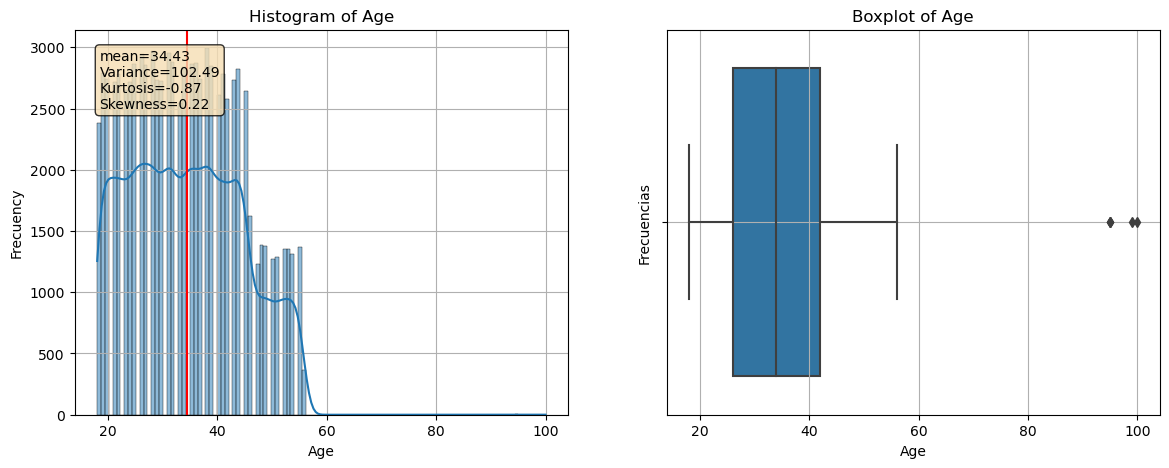

In [53]:
# Vamos a ver la distribución de la Edad
# Distribución (histograma) de la variable cantidad de alquileres
histogram_box(data_credit, 'Age')

In [109]:
# Se encontraron en el dataset valores desde -500 años, que también son Outliers
# Vamos a contar los valores que tienen Edad Negativa o hasta Menores de 18 años.
### Cuenta entre >=10 a <18 Añps### - primero
##  Entre >=1 < 10 - segundo
### Los Menores a 
### revisar un patron entre los negativos y superiores a 100 --- revisar
### --- Edad-Movimientos-? Relacion

age18 = data_credit['Age'].apply(lambda x: float(x) if float(x) <18 else None).count()
print("Cantidad de Valores que tienen valores de Edad < 18 Años: ", age18)

Cantidad de Valores que tienen valores de Edad < 18 Años:  6592


In [105]:
# Se encontraron en el dataset valores desde -500 años, que también son Outliers
# Vamos a contar los valores que tienen Edad Negativa o hasta Menores de 18 años.
age18 = data_credit['Age'].apply(lambda x: float(x) if float(x) <18 else None).count()
print("Cantidad de Valores que tienen valores de Edad < 18 Años: ", age18)

Cantidad de Valores que tienen valores de Edad < 1 Años:  6592


In [106]:
cantidad_valores_imputar=age100+age18
print(cantidad_valores_imputar)
print("El porcentaje de valores de Edad 'Age' A Imputar es de :", (cantidad_valores_imputar/100000)*100 , '%')

8483
El porcentaje de valores de Edad 'Age' A Imputar es de : 8.483 %


#### 2.7.2.1.3 Visualización - 'Age'

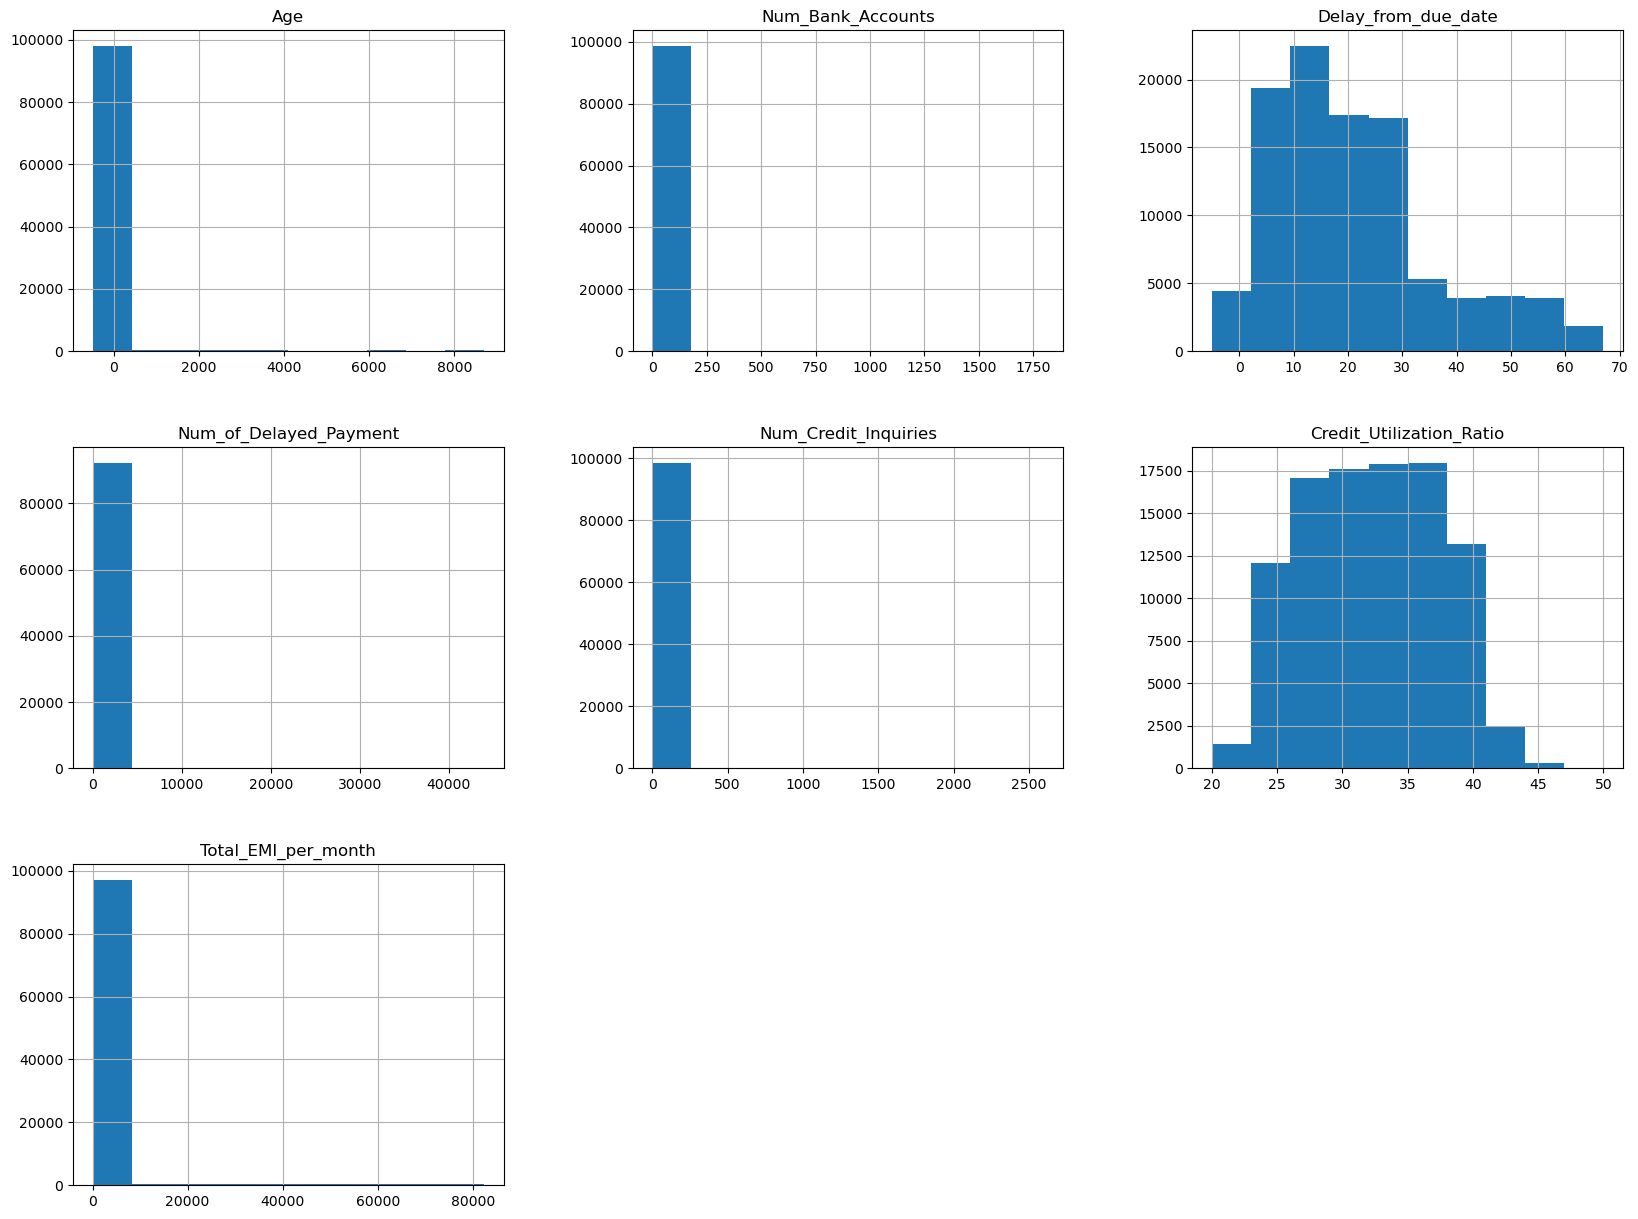

In [107]:
#Visualización de las variables numéricas con histogramas para determinar la distribución de los datos.
data_credit.hist(figsize=(20, 15))
plt.show()

In [101]:
cantidad_valores_imputar=age100+age18
print(cantidad_valores_imputar)
print("El porcentaje de valores de Edad 'Age' A Imputar es de :", (cantidad_valores_imputar/100000)*100 , '%')

8483
El porcentaje de valores de Edad 'Age' A Imputar es de : 8.483 %


In [101]:
cantidad_valores_imputar=age100+age18
print(cantidad_valores_imputar)
print("El porcentaje de valores de Edad 'Age' A Imputar es de :", (cantidad_valores_imputar/100000)*100 , '%')

8483
El porcentaje de valores de Edad 'Age' A Imputar es de : 8.483 %


In [ ]:
# Aplicar la función a las columnas deseadas para conversión a flotante

for col in data_credit.select_dtypes(include=['object']):
    data_credit['Age'] = convertir_a_flotante(data_credit['Age'])
    data_credit['Annual_Income'] = convertir_a_flotante(data_credit['Annual_Income'])
    data_credit['Num_of_Loan'] = convertir_a_flotante(data_credit['Num_of_Loan'])
    #data_credit['Changed_Credit_Limit'] = convertir_a_flotante(data_credit['Changed_Credit_Limit'])
    data_credit['Outstanding_Debt'] = convertir_a_flotante(data_credit['Outstanding_Debt'])
    #data_credit['Payment_of_Min_Amount'] = convertir_a_flotante(data_credit['Payment_of_Min_Amount'])
    data_credit['Amount_invested_monthly'] = convertir_a_flotante(data_credit['Amount_invested_monthly'])
    data_credit['Monthly_Balance'] = convertir_a_flotante(data_credit['Monthly_Balance'])
    
#Ahora vamos a convertir los que se necesitan a int
data_credit['Num_of_Loan'] = data_credit['Num_of_Loan'].apply(convertir_a_entero)
data_credit['Num_Credit_Inquiries'] = data_credit['Num_Credit_Inquiries'].apply(convertir_a_entero)    

data_credit

data_credit['Age'] = convertir_a_flotante1(data_credit, 'Age')
data_credit['Annual_Income'] = convertir_a_flotante1(data_credit, 'Annual_Income')
data_credit['Num_of_Loan'] = convertir_a_flotante1(data_credit, 'Num_of_Loan')
data_credit['Changed_Credit_Limit'] = convertir_a_flotante1(data_credit, 'Changed_Credit_Limit')
data_credit['Outstanding_Debt'] = convertir_a_flotante1(data_credit, 'Outstanding_Debt')
data_credit['Payment_of_Min_Amount'] = convertir_a_flotante1(data_credit, 'Payment_of_Min_Amount')
data_credit['Amount_invested_monthly'] = convertir_a_flotante1(data_credit, 'Amount_invested_monthly')
data_credit['Monthly_Balance'] = convertir_a_flotante1(data_credit, 'Monthly_Balance')
    
# ahora a entero los que requerimos
data_credit['Num_Credit_Inquiries'] = data_credit['Num_Credit_Inquiries'].apply(convertir_a_entero)


    

In [215]:
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Age                       94175 non-null   float64
 2   Occupation                100000 non-null  object 
 3   Annual_Income             93020 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_of_Loan               91339 non-null   float64
 6   Delay_from_due_date       100000 non-null  int64  
 7   Num_of_Delayed_Payment    92998 non-null   float64
 8   Changed_Credit_Limit      96323 non-null   float64
 9   Num_Credit_Inquiries      100000 non-null  float64
 10  Credit_Mix                100000 non-null  object 
 11  Outstanding_Debt          98991 non-null   float64
 12  Credit_Utilization_Ratio  100000 non-null  float64
 13  Payment_of_Min_Amount     0 non-null       fl

### 2.9 Nueva Verificación de Valores Nulos del Dataset
Una vez cambiados los tipos de datos e imputados por el valor promedio **(mean)** Volvemos a revisar si en efecto no tenemos valores Null

In [216]:
# Para Corroborar que los tipos de datos quedaron bien imputados, revisamos nuevamente Valores Null
missing_values = data_credit.isnull().sum()
print(missing_values)

ID                               0
Age                           5825
Occupation                       0
Annual_Income                 6980
Num_Bank_Accounts                0
Num_of_Loan                   8661
Delay_from_due_date              0
Num_of_Delayed_Payment        7002
Changed_Credit_Limit          3677
Num_Credit_Inquiries             0
Credit_Mix                       0
Outstanding_Debt              1009
Credit_Utilization_Ratio         0
Payment_of_Min_Amount       100000
Total_EMI_per_month              0
Amount_invested_monthly       8784
Payment_Behaviour                0
Monthly_Balance               1209
Credit_Score                     0
dtype: int64


### 2.10 Cambio de tipos de datos a variables que deben ser numéricas
Las Variables que son numéricas y continúan apareciendo como Object, deben estar debidamente tipeadas para poder analizar sus distribuciones y comportamientos.

In [117]:
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_of_Loan               100000 non-null  object 
 6   Delay_from_due_date       100000 non-null  int64  
 7   Num_of_Delayed_Payment    100000 non-null  float64
 8   Changed_Credit_Limit      100000 non-null  object 
 9   Num_Credit_Inquiries      100000 non-null  float64
 10  Credit_Mix                100000 non-null  object 
 11  Outstanding_Debt          100000 non-null  object 
 12  Credit_Utilization_Ratio  100000 non-null  float64
 13  Payment_of_Min_Amount     100000 non-null  ob

### 2.10.1 Revisión de Outliers - Age
Encontramos que hay valores de Edad de casi 1000 años y en el otro extremo de -500 años, lo que a simple vista son Outliers de valores reales de una edad de persona.

**En este punto vamos a iniciar en reasignar el tipo de datos para poder trabajar estadísticos básicos**

*Columna 500 outlier Valores mayores a 110 y menores a 0*

In [32]:
# Si se analizan de esta forma los datos estadísticos, tendremos valores erroneos
data_credit.describe()

,Age,Num_Bank_Accounts,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,100000.000000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,110.649700,17.091280,21.068780,27.754251,32.285173,1403.118217
std,686.244717,117.404834,14.860104,193.177339,5.116875,8306.041270
min,-500.000000,-1.000000,-5.000000,0.000000,20.000000,0.000000
25%,24.000000,3.000000,10.000000,3.000000,28.052567,30.306660
50%,33.000000,6.000000,18.000000,6.000000,32.305784,69.249473
75%,42.000000,7.000000,28.000000,9.000000,36.496663,161.224249
max,8698.000000,1798.000000,67.000000,2597.000000,50.000000,82331.000000


In [ ]:
# Argumentar porque dejamos entre 1 a 10 en el nro de cuentas bancarias
# regresion lineal y regresion logistica
#analisis de compoenntes principales (puede descrtar variables) - distr datos - método de deteccion de anomalias

In [ ]:
# Calcular la media del resto de datos del mismo DataFrame, al ser int la columna, parseamos float->int
media_entera = int(data_credit[data_credit['Num_Bank_Accounts'] <= 10]['Num_Bank_Accounts'].mean())

In [51]:
# Ordenar descendentemente por una columna en su mismo lugar sin crear nueva instancia
data_credit.sort_values('Num_Bank_Accounts', ascending=False, inplace=True)
data_credit

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
64537,34,Engineer,29902.22,1798,3,9,12,14.57,0.0,Standard,533.71,34.380248,Yes,66.210327,282.83977688221506,Low_spent_Small_value_payments,164.03506268873434,Standard
20277,55,Accountant,32946.22,1798,-100,3,3,10.03,4.0,Good,1330.02,21.743562,No,46.244585,264.3665957522356,Low_spent_Large_value_payments,245.94065263077442,Standard
29242,51,Media_Manager,35976.97,1794,3,2,0,9.61,2.0,Good,568.67,34.730228,No,53.686329,110.35505010932016,High_spent_Medium_value_payments,398.5667044159409,Good
69059,39,Writer,81438.56,1794,2,24,11,6.210000000000001,8.0,Standard,509.44,34.745910,Yes,84.273956,195.46631564445428,High_spent_Medium_value_payments,669.214395340143,Standard
35195,37,Developer,8499.645,1793,8,25,14,5.65,9.0,_,2573.1,34.367790,NM,34.700690,33.569203800126,Low_spent_Large_value_payments,283.4604811693365,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55637,40,Developer,30352.11,-1,-100,8,3,5.1099999999999985,0.0,Good,644.57,31.813259,No,16.483566,54.82132668337657,High_spent_Large_value_payments,400.42935709340685,Standard
30330,39,Engineer,128305.76,-1,2_,5,3,9.49,6.0,Good,1151.7,40.586736,No,196.587321,230.9223857499363,High_spent_Large_value_payments,855.9049597507532,Standard
47212,36,Lawyer,22312.07,-1,3,9,7,4.039999999999999,3.0,_,51.37,40.402442,No,32.891186,__10000__,High_spent_Small_value_payments,341.0972605265373,Good
47213,36,_______,22312.07,-1,3,10,2,9.04,3.0,Good,51.37,34.824443,No,32.891186,39.79680744547639,High_spent_Medium_value_payments,378.6459228513411,Good


In [54]:
# Ordenar descendentemente por una columna en su mismo lugar sin crear nueva instancia

data_credit['Num_Bank_Accounts'].unique()

array([1798, 1794, 1793, 1789, 1786, 1784, 1783, 1782, 1779, 1778, 1777,
       1775, 1774, 1771, 1770, 1769, 1766, 1765, 1764, 1763, 1760, 1756,
       1754, 1751, 1748, 1747, 1744, 1741, 1739, 1735, 1734, 1733, 1731,
       1730, 1727, 1725, 1724, 1722, 1719, 1715, 1714, 1712, 1711, 1709,
       1703, 1702, 1701, 1699, 1696, 1695, 1691, 1680, 1678, 1677, 1676,
       1675, 1671, 1670, 1669, 1668, 1666, 1665, 1662, 1657, 1656, 1655,
       1654, 1652, 1651, 1650, 1647, 1645, 1644, 1641, 1638, 1637, 1636,
       1634, 1632, 1631, 1630, 1628, 1627, 1626, 1624, 1622, 1621, 1620,
       1617, 1616, 1613, 1611, 1606, 1605, 1604, 1601, 1600, 1599, 1595,
       1594, 1592, 1591, 1589, 1588, 1583, 1581, 1580, 1578, 1577, 1576,
       1574, 1570, 1569, 1568, 1567, 1566, 1565, 1564, 1562, 1561, 1560,
       1558, 1557, 1553, 1551, 1549, 1547, 1544, 1543, 1540, 1539, 1536,
       1534, 1533, 1530, 1529, 1528, 1526, 1525, 1523, 1522, 1520, 1517,
       1516, 1511, 1506, 1504, 1503, 1502, 1501, 14

In [49]:
# Definir una función lambda para convertir los valores y contar aquellos mayores a 10

registros_mayores_a_10 = data_credit['Num_Bank_Accounts'].apply(lambda x: float(x) if float(x) >10 else None).count()
registros_entre_1_a_10_cuentas= data_credit['Num_Bank_Accounts'].apply(lambda x: float(x) if (float(x) <=10 and float(x) !=-1) else None).count()
registros_menores_0 = data_credit['Num_Bank_Accounts'].apply(lambda x: float(x) if float(x) <0 else None).count()
print("Registros con valores registros_mayores_a_10:", registros_mayores_a_10)
print("Registros con valores registros_entre_1_a_10_cuentas:",registros_entre_1_a_10_cuentas)
print("Registros con valores registros_menores_0:", registros_menores_0)
suma=registros_mayores_a_10+registros_entre_1_a_10_cuentas+registros_menores_0
print("La suma de los diferentes tipos de valores es: ", suma)



Registros con valores registros_mayores_a_10: 1324
Registros con valores registros_entre_1_a_10_cuentas: 98655
Registros con valores registros_menores_0: 21
La suma de los diferentes tipos de valores es:  100000


In [41]:
#registros_mayores_a_10 = data_credit['Num_of_Loan'].apply(lambda x: float(x) if float(x) >10 else None).count()

In [44]:
data_credit.sort_values('Annual_Income', ascending=False, inplace=True)
data_credit

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
27776,27,Media_Manager,13492836000000002,1,0,14,110.0,7.25,2.0,Good,587.0,40.009288,No,0.000000,430.9500050894089,High_spent_Medium_value_payments,938.7529949105913,Good
27777,27,Media_Manager,13492836000000002,1,0,14,90.0,7.25,2.0,Good,587.0,34.778510,No,0.000000,303.760618722244,High_spent_Medium_value_payments,1065.9423812777563,Good
27778,27,Media_Manager,13492836000000002,1,0,14,110.0,7.25,7.0,Good,587.0,40.245348,No,0.000000,171.83274218292573,High_spent_Large_value_payments,1187.8702578170744,Standard
27779,27,Media_Manager,13492836000000002,1,0,14,110.0,7.25,7.0,Good,587.0,32.994283,NM,0.000000,249.7149220139803,High_spent_Large_value_payments,1109.9880779860198,Good
27780,27,Media_Manager,13492836000000002,1,0,14,110.0,7.25,7.0,Good,587.0,28.375763,NM,0.000000,1037.7751607294438,Low_spent_Medium_value_payments,361.92783927055643,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,16,Scientist,70465,4,5,33,120.0,8.82,6.0,Standard,1765.67,30.998418,Yes,23.250415,47.34159252071101,!@9#%8,254.92882598281216,Poor
5933,16,Scientist,70465,4,5,29,NaN,8.82,6.0,Standard,1765.67,33.627522,Yes,23.250415,18.940134822180525,Low_spent_Medium_value_payments,273.3302836813427,Poor
5934,16,Scientist,70465,4,5,29,90.0,8.82,6.0,Standard,1765.67,33.343514,Yes,23.250415,30.04925698360348,Low_spent_Large_value_payments,252.2211615199197,Poor
5935,16,Scientist,70465,4,5_,29,120.0,8.82,6.0,Standard,1765.67,38.367541,NM,23.250415,15.089684600508251,Low_spent_Small_value_payments,287.18073390301487,Poor


In [42]:
# Aplicar la función a la columna 'columna_objeto'
data_credit['Annual_Income'] = data_credit['Annual_Income'].apply(aplicar_convertir_a_entero)
data_credit

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23,Scientist,1911412,3,4,3,70.0,11.27,4.0,_,809.98,26.822620,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,23,Scientist,1911412,3,4,-1,NaN,11.27,4.0,Good,809.98,31.944960,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,-500,Scientist,1911412,3,4,3,70.0,_,4.0,Good,809.98,28.609352,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,23,Scientist,1911412,3,4,5,40.0,6.27,4.0,Good,809.98,31.377862,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,23,Scientist,1911412,3,4,6,NaN,11.27,4.0,Good,809.98,24.797347,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25,Mechanic,3962899,4,2,23,70.0,11.5,3.0,_,502.38,34.663572,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.86622816574095,Poor
99996,25,Mechanic,3962899,4,2,18,70.0,11.5,3.0,_,502.38,40.565631,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.651610435322,Poor
99997,25,Mechanic,3962899,4,2,27,60.0,11.5,3.0,Good,502.38,41.255522,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.8090832742814,Poor
99998,25,Mechanic,3962899,4,2,20,NaN,11.5,3.0,Good,502.38,33.638208,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.1649785257098,Standard


In [28]:
# Calcular la media del resto de datos del mismo DataFrame, al ser int la columna, parseamos float->int
media_entera = int(data_credit[data_credit['Num_Bank_Accounts'] <= 10]['Num_Bank_Accounts'].mean())
print(media_entera)

5


In [29]:
# Imputar valores mayores que 10 con la media calculada
data_credit.loc[data_credit['Num_Bank_Accounts'] > 10, 'Num_Bank_Accounts'] = media_entera
data_credit.loc[data_credit['Num_Bank_Accounts'] < 0, 'Num_Bank_Accounts'] = 0
data_credit.describe()

,Num_Bank_Accounts,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,5.362460,21.068780,27.754251,32.285173,1403.118217
std,2.576037,14.860104,193.177339,5.116875,8306.041270
min,0.000000,-5.000000,0.000000,20.000000,0.000000
25%,3.000000,10.000000,3.000000,28.052567,30.306660
50%,5.000000,18.000000,6.000000,32.305784,69.249473
75%,7.000000,28.000000,9.000000,36.496663,161.224249
max,10.000000,67.000000,2597.000000,50.000000,82331.000000


In [30]:
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 20277 to 30330
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  object 
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  object 
 3   Num_Bank_Accounts         100000 non-null  int64  
 4   Num_of_Loan               100000 non-null  object 
 5   Delay_from_due_date       100000 non-null  int64  
 6   Num_of_Delayed_Payment    92998 non-null   object 
 7   Changed_Credit_Limit      100000 non-null  object 
 8   Num_Credit_Inquiries      98035 non-null   float64
 9   Credit_Mix                100000 non-null  object 
 10  Outstanding_Debt          100000 non-null  object 
 11  Credit_Utilization_Ratio  100000 non-null  float64
 12  Payment_of_Min_Amount     100000 non-null  object 
 13  Total_EMI_per_month       100000 non-null  flo

In [31]:
data_credit.sample(15)


,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
63392,43,Entrepreneur,36229.54,2,1,6,4,_,3.0,Good,1274.92,27.289934,No,19.999566,53.39108537915028,High_spent_Medium_value_payments,477.8221814550429,Standard
50531,48,Entrepreneur,27109.79,3,3_,28,12,9.26,1.0,_,320.07,27.353165,No,43.378708,__10000__,Low_spent_Large_value_payments,247.5257486679093,Standard
27727,20,Architect,68369.88,4,2,13,20,9.66,2.0,Standard,40.13,35.926469,No,40101.000000,606.2918442215082,Low_spent_Small_value_payments,152.46670859737802,Standard
67570,28,Media_Manager,65085.76,6,7,18,21,3.06,7.0,_,1413.88,39.358544,Yes,288.121224,184.92611979217838,High_spent_Medium_value_payments,347.2339897233144,Standard
54343,27,Mechanic,35540.74,3,2,6,1,9.45,1.0,Good,1148.21,39.579060,No,52.412166,61.35940043246094,High_spent_Large_value_payments,449.5012672812215,Good
5969,32,Accountant,21546.93,5,1,33,17,9.41,1.0,Standard,313.06,25.307317,No,9.878118,71.20922433307551,Low_spent_Small_value_payments,365.07040788287657,Standard
45373,32,Engineer,51715.68000000001,8,7,23,24,28.99,11.0,Bad,3812.9,38.401725,Yes,168.517947,95.31084895828484,High_spent_Large_value_payments,429.13520417513575,Standard
95289,42,Manager,31239.32,9,6,58,22,28.23,9.0,Bad,2585.96,38.844529,Yes,141.099627,27.803444349168448,High_spent_Large_value_payments,322.42459524629936,Standard
91674,17,Engineer,13347.835_,5,2,12,19,18.66,4.0,Standard,536.5,36.079404,Yes,15.758047,72.90739059299474,High_spent_Small_value_payments,277.76652088101685,Standard
97287,22,Musician,87520.66,0,4,0,5,6.37,3.0,Good,1167.75,38.984544,NM,149.599343,163.9002232234569,High_spent_Large_value_payments,640.7392668003707,Good


In [33]:
# Descripción estadística inicial de datos categóricos
#print(data_credit['Num_of_Delayed_Payment'])
# Ordenar descendentemente por una columna en su mismo lugar sin crear nueva instancia
data_credit.sort_values('Num_of_Delayed_Payment', ascending=False, inplace=True)
data_credit

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
21892,43,_______,62359.82,4,1,14,9_,8.94,3.0,Standard,250.56,38.196630,Yes,29.765763,373.35812740543525,Low_spent_Small_value_payments,398.94127629788176,Standard
68351,23,Manager,46301.96,8,2,18,9_,1.86,5.0,Standard,1288.02,24.325964,No,70.973680,415.08728659390886,Low_spent_Small_value_payments,171.9887000647196,Standard
72824,27,Writer,12498.945,5,4,20,9_,13.1,0.0,Standard,695.46,35.400506,No,30.871491,__10000__,Low_spent_Large_value_payments,311.2943398113902,Standard
90680,28,Journalist,27706.71,8,3,9,9_,10.49,1.0,Standard,204.35,26.114611,No,49.171833,230.5707130573753,Low_spent_Small_value_payments,251.9467041438417,Standard
13073,44,Doctor,128331.42,5,2,7,9_,3.33,2.0,Good,462.96,39.738738,No,114.993991,732.7637418657132,Low_spent_Medium_value_payments,501.0707668305828,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8591,35,Engineer,42018.21,0,2,3,NaN,15.27,5.0,Good,421.99,38.482777,No,46.287657,67.45480558017283,High_spent_Medium_value_payments,490.70928754165743,Good
24411,33,Doctor,18514.195,0,2,4,NaN,5.23,3.0,Good,62.75,37.713915,No,20.050474,206.3892281051553,!@9#%8,234.94525667040696,Standard
47855,48,Lawyer,19749.315,0,2,7,NaN,8.68,2.0,Good,1286.51,36.000086,No,17.849500,89.77687794346944,High_spent_Small_value_payments,315.9512468849008,Standard
24570,55,Mechanic,85954.42,0,3,15,NaN,3.66,3.0,_,791.46,28.513427,No,128.555233,618.499454984739,Low_spent_Medium_value_payments,269.632144907868,Standard


In [34]:
# Convertir la columna de objetos a enteros
# Aplicar la función convertir_a_entero a la columna 'columna_objeto'
data_credit['Num_of_Delayed_Payment']= data_credit['Num_of_Delayed_Payment'].apply(lambda x: convertir_a_entero(x))


In [35]:
data_credit.sort_values('Num_of_Delayed_Payment', inplace=True)
data_credit

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
55802,45,Mechanic,84833.62,5,4,4,-3.0,-1.95,2.0,_,557.38,24.809356,No,274.944204,729.6958431094658,Low_spent_Small_value_payments,NaN,Good
37397,25,Mechanic,44864.55,4,4,8,-3.0,9.34,1.0,Good,441.24,31.021709,No,107.490080,495.4375693711546,Low_spent_Small_value_payments,71.14360066065728,Poor
84664,22,_______,21677.905,1,1,11,-3.0,0.71,0.0,Good,585.36,24.486309,No,11.503369,32.86348047558055,High_spent_Medium_value_payments,391.58235885749565,Good
37175,45,Engineer,40894.22,5,0,5,-3.0,3.07,4.0,Good,1243.45,27.313502,No,0.000000,111.33892206518287,High_spent_Medium_value_payments,460.8462446014838,Good
73045,869,Engineer,59986.0,2,1,3,-3.0,8.54,6.0,Good,275.56,29.741571,No,40.243706,323.3277253153181,Low_spent_Small_value_payments,406.5119020597635,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8591,35,Engineer,42018.21,0,2,3,NaN,15.27,5.0,Good,421.99,38.482777,No,46.287657,67.45480558017283,High_spent_Medium_value_payments,490.70928754165743,Good
24411,33,Doctor,18514.195,0,2,4,NaN,5.23,3.0,Good,62.75,37.713915,No,20.050474,206.3892281051553,!@9#%8,234.94525667040696,Standard
47855,48,Lawyer,19749.315,0,2,7,NaN,8.68,2.0,Good,1286.51,36.000086,No,17.849500,89.77687794346944,High_spent_Small_value_payments,315.9512468849008,Standard
24570,55,Mechanic,85954.42,0,3,15,NaN,3.66,3.0,_,791.46,28.513427,No,128.555233,618.499454984739,Low_spent_Medium_value_payments,269.632144907868,Standard


In [36]:
data_credit.sample(15)

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
34844,21,Journalist,20917.51,6,9,23,13.0,6.92,7.0,Bad,1743.25,22.621489,Yes,151.414699,194.73530375143062,Low_spent_Small_value_payments,98.56258079400676,Poor
23808,23,Teacher,90182.31,0,3,15,2.0,6.47,4.0,Good,1283.66,28.168328,No,139.399184,174.1826176254456,High_spent_Medium_value_payments,688.9374479142668,Poor
7452,34,Writer,8312.495,6,4,25,17.0,7.71,8.0,Standard,1803.31,38.057984,Yes,20.156252,43.44005413035204,Low_spent_Medium_value_payments,305.77448579277893,Standard
63923,31,Entrepreneur,17443.94,10,5,42,22.0,21.69,7.0,_,2816.57,39.854887,Yes,55.673626,193.3143313918427,Low_spent_Small_value_payments,212.4782096545332,Standard
94916,27,Mechanic,20987.56,10,7,42,24.0,5.07,9.0,Bad,2553.42,25.681300,Yes,104.602095,122.26953703419576,Low_spent_Large_value_payments,219.82470162769326,Poor
64100,50,Entrepreneur,65544.12,3,2,7,0.0,8.2,1.0,_,1357.63,39.197737,No,71.716893,65.26617665214492,High_spent_Medium_value_payments,644.1179300166983,Standard
38744,21,Doctor,126026.19,0,-100,13,3.0,12.61,4.0,Good,1475.49,38.596993,No,250.116972,__10000__,High_spent_Large_value_payments,907.809642655455,Standard
84529,41,Developer,127928.68,2,4,26,NaN,15.0,NaN,Good,1361.41,27.545662,No,240.771933,540.6964975669864,Low_spent_Large_value_payments,536.5039031025968,Poor
91522,-500,Engineer,166658.68,5,2,1,8.0,9.95,1.0,Good,959.2,32.431204,NM,222.285727,1212.158621055544,Low_spent_Large_value_payments,241.37798503195225,Good
31654,44,Developer,36886.49,4,0_,4,15.0,16.54,9.0,Standard,1251.85,26.999533,Yes,0.000000,241.71372378037046,Low_spent_Small_value_payments,357.1736928862963,Standard


In [40]:
# Crear una función para aplicar a la columna
def aplicar_convertir_a_entero(valor):
    return convertir_a_entero(valor)

# Aplicar la función a la columna 'columna_objeto'
data_credit['Num_of_Delayed_Payment'] = data_credit['Num_of_Delayed_Payment'].apply(aplicar_convertir_a_entero)
data_credit

,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23,Scientist,19114.12,3,4,3,70.0,11.27,4.0,_,809.98,26.822620,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,23,Scientist,19114.12,3,4,-1,NaN,11.27,4.0,Good,809.98,31.944960,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,-500,Scientist,19114.12,3,4,3,70.0,_,4.0,Good,809.98,28.609352,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,23,Scientist,19114.12,3,4,5,40.0,6.27,4.0,Good,809.98,31.377862,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,23,Scientist,19114.12,3,4,6,NaN,11.27,4.0,Good,809.98,24.797347,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25,Mechanic,39628.99,4,2,23,70.0,11.5,3.0,_,502.38,34.663572,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.86622816574095,Poor
99996,25,Mechanic,39628.99,4,2,18,70.0,11.5,3.0,_,502.38,40.565631,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.651610435322,Poor
99997,25,Mechanic,39628.99,4,2,27,60.0,11.5,3.0,Good,502.38,41.255522,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.8090832742814,Poor
99998,25,Mechanic,39628.99,4,2,20,NaN,11.5,3.0,Good,502.38,33.638208,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.1649785257098,Standard


In [43]:
# Ejemplos de uso
print(convertir_a_entero("123"))  # Salida: 123
print(convertir_a_entero("abc123"))  # Salida: None
print(convertir_a_entero("123_456"))  # Salida: 123456
print(convertir_a_entero("-123#45"))  # Salida: -12345

123.0
123.0
123456.0
-12345.0


In [40]:
# Definir una función lambda para convertir los valores y contar aquellos mayores a 10
#registros_mayores_a_100 = data_credit['Num_of_Delayed_Payment'].apply(lambda x: float(x) if float(x) >100 else None).count()
#print("Registros con valores mayores a 100:", registros_mayores_a_100)

In [35]:
# Número de valores nulos por columna
tot = len(data_credit)
nulos = (data_credit.isnull().sum())
nulidad = pd.DataFrame( {'Variable':nulos.index, 'Porcentaje de Nulidad': nulos.values} )
nulidad

,Variable,Porcentaje de Nulidad
0,Age,0
1,Occupation,0
2,Annual_Income,0
3,Num_Bank_Accounts,0
4,Num_of_Loan,0
5,Delay_from_due_date,0
6,Num_of_Delayed_Payment,9746
7,Changed_Credit_Limit,0
8,Num_Credit_Inquiries,1965
9,Credit_Mix,0


In [55]:
data_credit['Credit_Score']

64537    Standard
20277    Standard
29242        Good
69059    Standard
35195        Poor
           ...   
55637    Standard
30330    Standard
47212        Good
47213        Good
43690        Poor
Name: Credit_Score, Length: 100000, dtype: object

De los estadísticos principales podemos observar:--**pendiente por hacer** ---
* Tenemos un total de registros de: 100.000
* <strong>Las variables con datos nulos y sus respectivas cantidades son:</strong><br>
<ol>
    <li>Num_of_Delayed_Payment, con 7002 Registros Faltantes </li>
    <li>Num_Credit_Inquiries, con 1935 Registros Faltantes </li>
    <li>Amount_invested_monthly, con 4479 Registros Faltantes </li>
    <li>Monthly_Balance , con 1200 Registros Faltantes </li>
</ol>
<br>
* Se presume un error en la Desviación estándar en Num_Bank_Accounts, debe corregirse los datos que no estén entre los valores aceptables. Debe revisarse






* En promedio, los valores de sólidos se encuentran muy por encima (el doble) de lo considerado como aceptable. Vemos que en general las muéstras de agua contienen altos contenidos de sólidos ya que incluso desde el Q1, todos los valores de los cuartiles superan el rango aceptado, el cuál, según el diccionario de los datos, se encuentra entre 500 mg/l y 1000 mg/l.

* En general, tanto el valor promedio como los los tres cuartiles del nivel de cloraminas se encuentra muy por encima de lo aceptado, el cuál según el diccionario de los datos, corresponde a 4ppm.

* En general, tanto el valor promedio como los los tres cuartiles del nivel de sulfatos se encuentra muy por encima de lo aceptado, el cuál según el diccionario de los datos, corresponde a 30 mg/l.

* En cuanto a la Conductividad, el promerio se encuentra un poco por encima de lo aceptado como potable, y en general, los datos contienen una alta conductividad. Esto se evidencia ya que solo hasta el Q1 los datos poseen un valor de conductividad aceptable.

* En general, los Trihalometanos se encuentran por debajo del límite el cuál según el diccionario de los datos, corresponde a 80 ppm. Podemos evidenciarlo a partir de los estadísticos principales ya que tanto el promedio, como los datos hasta el Q3 se encuentran por debajo del límite.

* Con respecto a la turbidez, en general los datos se encuentran dentro del rango permitído por la OMS (5 NTU) pero solo hasta antes del Q1, los datos poseen el nivel de turbidez aceptable según el CWG.


NOTAS NICOLAS:
https://github.com/contreras-juan/UPTC_Diplomado_Ciencia_de_Datos/blob/main/EDA/Proyectos/1)-Proyecto%201_EDA.ipynb - mas enfocado a graficacion, y otras coas
https://github.com/contreras-juan/UPTC_Diplomado_Ciencia_de_Datos/blob/main/EDA/Proyectos/2)-Proyecto%202_EDA.ipynb - preprocesamiento e imputacion 2.2 section




1- Analisis Univariado de cada variable (Boxplot), Que tanto impacto tienen los outlayers  dentro de la distribución, 
 Revisar si los valores outlayer se ubican muy fuera de la distribución de los datos.
revisar las escalas de ma


1B, apartar las variables categóricas a numéricas puso el ejemplo de estado civil, deben estar consistentes, por ejemplo si es 2. pasarlo a 3 (viudo por ejemplo)

2- revisar el impacto de imputacion de datos (prefeeriblemente de imputacion de los datos) - Se encuentra en el proyecto 2(2.2) 
2- Eliminar los duplicados...
Recomendar la imputacion knn, o puede ser por promedio, pero se recomienda KNN
Generar nombres de variables diferentes y hacer dataset nuevos para cada conjunto de transformaciones

3- se hace la verificacion de la imputacion

ponemos el dataset antes y despues de la imputacion y revisar el cambio en las distribuciones... si está por el 30% se debe revisar esta en el proyecto 2 2.3
Probar diferents imputaciones (promedios y knn y hacer la validacion... a manera de prueba) - 'revision de la hipotesis nula' 
0.05 > p   -> hubo cambio en las distribuciones
0.05 < p   -> no hay evidencia de que hubo cambio


4- hacer una exploracion univariada, bivariada y multivariada antes y despues de las imputaciones - deben tener conservaciones de las relaciones de variables, y que el cambio sea casi imperceptible





